In [1]:
from utils.configuration import get_config_from_json
from utils.training_utilities import set_GPU
from utils.plotting_traces import plot_traces
from seq2point.seq2point import SEQ2POINT
from refit_loader.data_loader import REFIT_Loader
from dataset_management.dataloader import Seq2PointDataLoader
import builtins
import os
import torch
from pprint import pprint

builtins.MODEL_CONFIG = get_config_from_json(description="Model Parameters", config_file="configs/model_config.json")
builtins.DATASET_CONFIG = get_config_from_json(description="Dataset Management", config_file="configs/dataset_config.json")
builtins.TRAINING_CONFIG = get_config_from_json(description="Training Configuration", config_file="configs/training_config.json")
builtins.PLOT_CONFIG = get_config_from_json(description="Plot Settings", config_file="configs/plot_config.json")

In [2]:
import pandas as pd
import numpy as np

In [3]:
dataloaders = Seq2PointDataLoader(target_appliance='kettle', target_houses= {'TRAIN' : [2], 'VALIDATE': [2], 'TEST':[2]}, proportion= {'train_percent':0.6, 'validate_percent':0.2}, subset_days=1)

Followings are the refit_loader configuration 
{'DATA_FOLDER': 'data/refit/', 'DATA_TYPE': '.csv', 'README_FILE': 'refit_loader/REFIT_Readme.txt', 'REFIT_HOUSES': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21]}

Loading specified buildings: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21]
Parsing the readme file specified: refit_loader/REFIT_Readme.txt
Loading data for appliance KETTLE ...
Fetching KETTLE data for House 2
Resampling for house number:  2
Creating 1 smaller subsets from complete dataset of House 2
Estimating active durations of: kettle


In [4]:

network = SEQ2POINT().to(set_GPU())

train_loss, validation_loss, tp, tn, fp, fn = network.run(dataloaders.train_dataloader, dataloaders.validation_dataloader)



Initializing SEQ2POINT model archiecture

Followings are the Model Parameters of your network architecture..
{'CONV_KERNEL': [10, 8, 6, 5, 5],
 'CONV_LAYERS': 5,
 'CONV_PADDING': 0,
 'CONV_STRIDE': 1,
 'DESCRIPTION': 'Model Parameters',
 'INPUT_CHANNELS': [1, 30, 30, 40, 50],
 'LEFT_PAD': [4, 3, 2, 2, 2],
 'LINEAR_INPUT': [29950, 1024],
 'LINEAR_LAYERS': 2,
 'LINEAR_OUTPUT': [1024, 1],
 'OUTPUT_CHANNELS': [30, 30, 40, 50, 50],
 'POOL_KERNEL': [],
 'POOL_STRIDE': [],
 'RIGHT_PAD': [5, 4, 3, 2, 2],
 'SEQUENCE_LENGTH': 599}

SEQ2POINT model archiecture has been initialized


Followings are the Training Configuration of your experiment..
{'DESCRIPTION': 'Training Configuration',
 'EARLY_STOPPING_THRESHOLD': 5,
 'LEARNING_RATE': 0.0001,
 'LOAD_MODEL': 'models/best_model/2022-11-18_best_loss_65685.pt',
 'LOSS': 'nn.MSELoss',
 'LOSS_REDUCTION': 'mean',
 'NUM_EPOCHS': 20,
 'OPTIMIZER': 'optim.Adam',
 'PRE_TRAINED_MODEL_FLAG': False,
 'SAVE_MODEL': 'models/',
 'TEST_BATCH_SIZE': 64,
 'TRAIN_BA

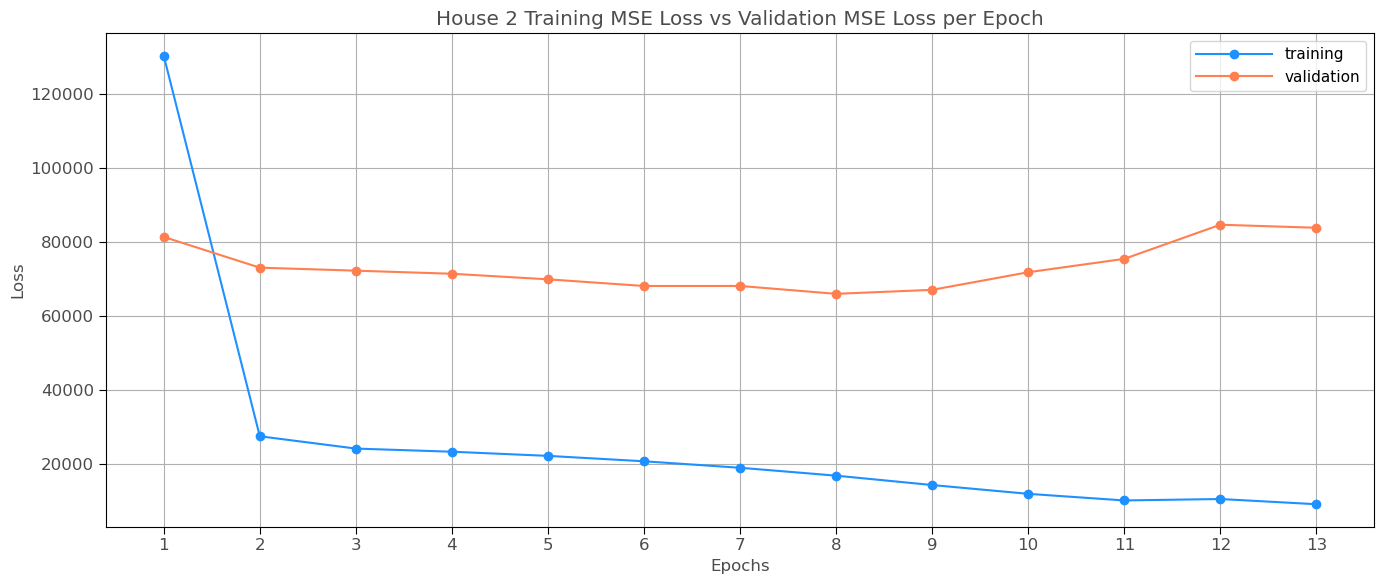

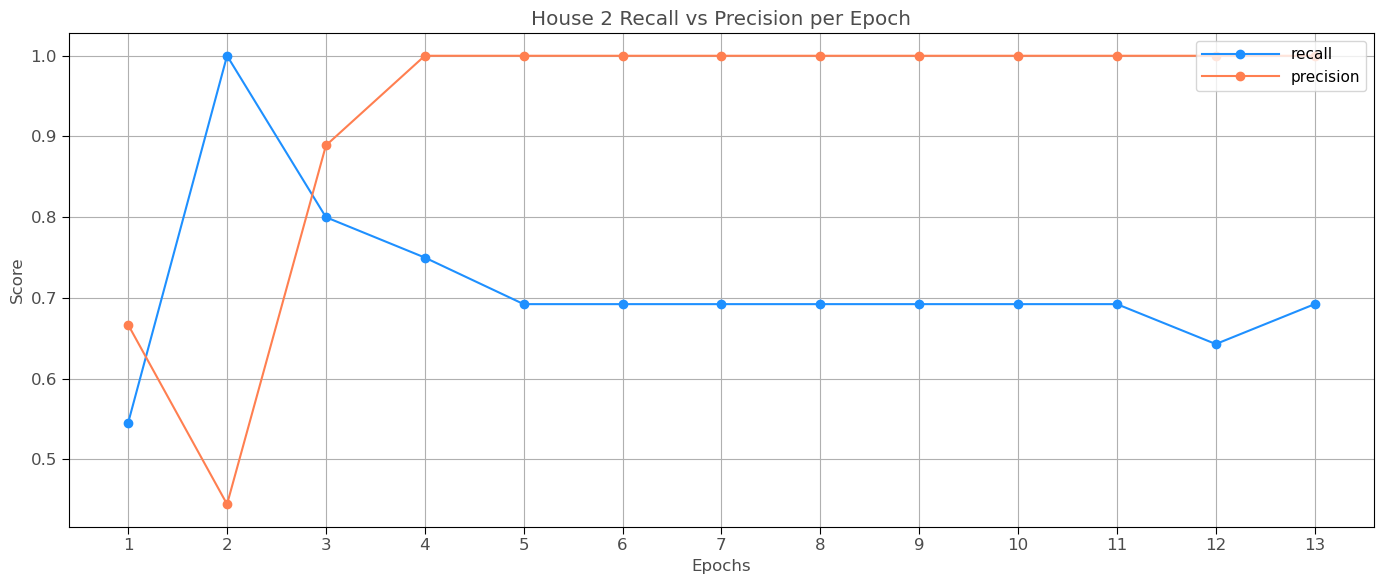

In [5]:
plot_traces(traces = [train_loss, validation_loss], labels=['training', 'validation'], axis_labels=['Epochs', 'Loss'], title='House 2 Training MSE Loss vs Validation MSE Loss per Epoch')

plot_traces(traces = [np.array(tp) / np.array((np.array(tp) + np.array(fn))) , np.array(tp) / np.array((np.array(tp) + np.array(fp)))], 
            labels=['recall', 'precision'], axis_labels=['Epochs', 'Score'], title='House 2 Recall vs Precision per Epoch')

In [6]:
# test_network = SEQ2POINT().to(set_GPU())
# test_loss, tp, tn, fp, fn = test_network.inference(dataloaders.test_dataloader)

In [7]:
# df = pd.DataFrame({'Test MSE': np.round(test_loss), 'TP': tp, 'FN': fn, 'FP': fp, 'TN': tn , 
#                    'Recall': np.array(tp) / np.array((np.array(tp) + np.array(fn))) , 'Precision': np.array(tp) / np.array((np.array(tp) + np.array(fp)))})
# df

In [8]:
df.describe()

NameError: name 'df' is not defined

In [ ]:
df.to_csv('Experiment3_House2_days10_test.csv')

In [ ]:
# df = pd.DataFrame({'Epoch':np.arange(1,13), 'Train MSE':np.round(train_loss), 'Validation MSE': np.round(validation_loss), 'TP': tp, 'FN': fn, 'FP': fp, 'TN': tn , 
#                    'Recall': np.array(tp) / np.array((np.array(tp) + np.array(fn))) , 'Precision': np.array(tp) / np.array((np.array(tp) + np.array(fp)))}).set_index('Epoch')
# df

In [ ]:
# df.to_csv('Experiment3_House2_days10.csv')